### Libraries

In [2]:
import os
from os import listdir
from os.path import join, isfile
from PIL import Image

import numpy as np
import pandas as pd
# import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import transforms, Lambda
from torch.utils.data import random_split
import random
from torch.utils.data import DataLoader
import glob
#!pip install git+https://github.com/facebookresearch/fvcore.git

In [3]:
pwd

'/scratch/student/shokoofa'

In [4]:
original_address = '/scratch/student/shokoofa/'
# '/home/zahra.ghods'
# '/home/student/shokoofa/Downloads/dataset/'
# 'C:/echo/dataset
# '/scratch/student/shokoofa/'

In [5]:
paths = glob.glob(os.path.join(original_address + '/dataset/**/*', '*')) #numebr of all samples per patients
len(paths)

207783

### Load the csv file containing the image file names and corresponding labels

In [6]:
info = pd.read_csv(os.path.join(original_address , 'labels_file.csv'))

In [7]:
info.columns

Index(['RPeak1', 'RPeak2', 'sample_path', 'frame_size', 'potential_frame_size',
       'label'],
      dtype='object')

In [8]:
info['sample_path'] = info['sample_path'].astype(str)
info['path'] = info['sample_path'].apply(lambda x: '/'.join(x.split(' ')[:2]))
data_path = info['path'].values
data_labels = info['label'].values
data_fsize = info['frame_size'].values + 1
data_final_fsize = info['potential_frame_size'].values


In [9]:
data_path[0]

'6fwt32TiT_KD-QU8t64_eg/65'

### Preprocessing

In [10]:
# def preprocessing(image_array, k = 100):
#         slices, ch, height, width = image_array.shape

#         mask = torch.zeros((ch, height, width), dtype=torch.uint8)
#         steps = min(k, slices)
#         for i in range(steps - 1):
#             mask[image_array[i, :, :, :] != image_array[i + 1, :, :, :]] = 1

#         output = image_array * mask

#         return output

### Define Transformers

In [11]:
class CustomCrop(object):
    """Crops the bottom 1/10 of the height and 1/8 of the width of the image."""
    def __call__(self, img):
        w, h = img.size
        new_h = h - h // 15
        top = 0
        left = w // 10
        return img.crop((left, top, w, new_h))

train_transform = transforms.Compose([
    CustomCrop(),
    # transforms.Resize((224, 224)),
    #  transforms.Resize((256, 256)),
    transforms.Resize((299, 299)), # JUST FOR INCEPTION
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225]),
    # Lambda(lambda x: x/255)
])


### Map images to their labels

In [12]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, data_fsize, data_final_fsize, transform=None):
        self.paths = paths
        self.labels = labels
        self.data_fsize = data_fsize
        self.data_final_fsize = data_final_fsize
        self.transform = transform
        self.valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
                            }

    def __len__(self):
        return len(self.paths)

    def preprocessing(self, image_array, k = 100):
        slices, ch, height, width = image_array.shape

        mask = torch.zeros((ch, height, width), dtype=torch.uint8)
        steps = min(k, slices)
        for i in range(steps - 1):
            mask[image_array[i, :, :, :] != image_array[i + 1, :, :, :]] = 1

        output = image_array * mask
        return output

    def address(self,index):
        return original_address + '/dataset/' + self.paths[index]
    
    def __getitem__(self, index):
        # Get the filename and label for the current index
        filepath = original_address + '/dataset/' + self.paths[index]
        label = self.labels[index]
        label = torch.tensor([self.valid_labels[str(label)]])

        # sort the image in based on the order of the slices saved in the folder
        imgs_paths = sorted(glob.glob(os.path.join(filepath, '*')), key=lambda name: int(os.path.basename(name).split('_')[-1].split('.')[0]))

        images_list = []
        for img_path in imgs_paths:
            image = Image.open(img_path)
            if self.transform:
                image = self.transform(image)
            images_list.append(image)
            if len(images_list) >= 10:
                break

        # creating a 3D tensor image
        sequence_tensor = torch.stack(images_list)
        # sequence_tensor = sequence_tensor.permute(0,2,3,1)
        
        preprocessed_d = self.preprocessing(sequence_tensor)

        # Return the image and label as tensors
        return preprocessed_d, label

    # def number_of_classes(self):
    #   return self.data[:,1].max() + 1

In [13]:
def visualization(image, label):
  plt.figure(figsize= (10,8))
  # im = Image.fromarray(image.permute(1,2,0))
  # plt.imshow(image.permute(1,2,0))
  plt.imshow(image, cmap= 'gray')
  plt.title(label.item())
  plt.xticks([])
  plt.yticks([])
  plt.show()

### Load the train dataset from the folder

In [14]:
total_data = CustomDataset(data_path, data_labels, data_fsize, data_final_fsize, train_transform)

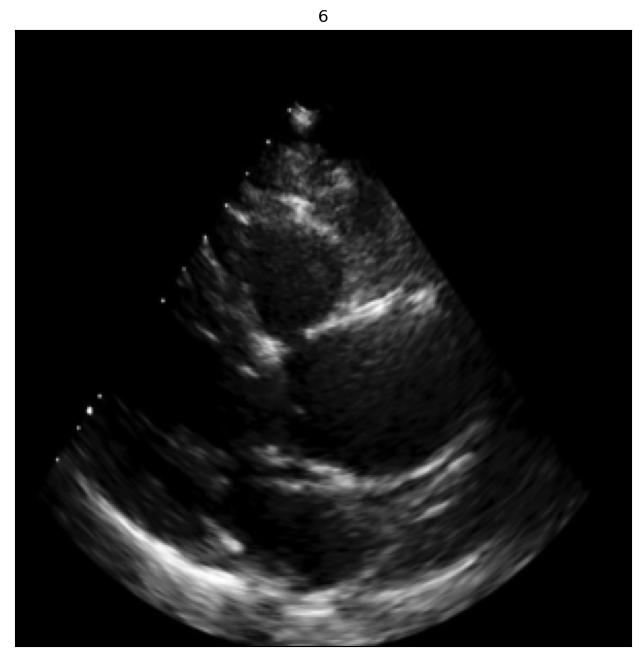

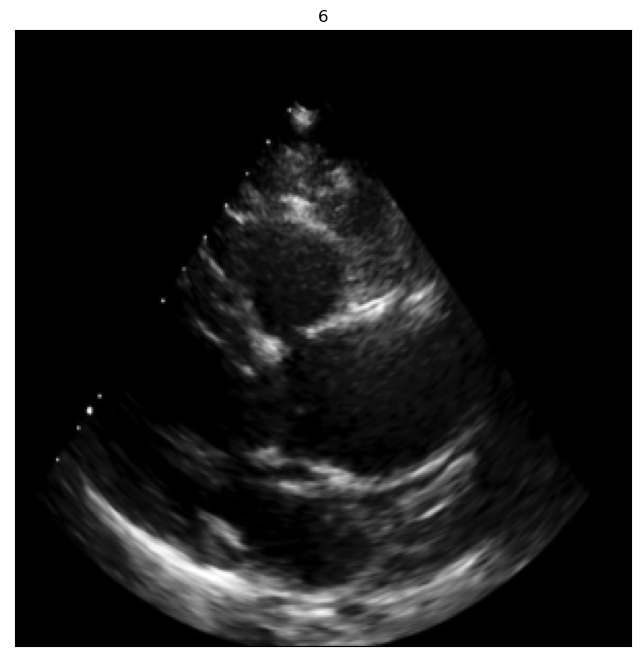

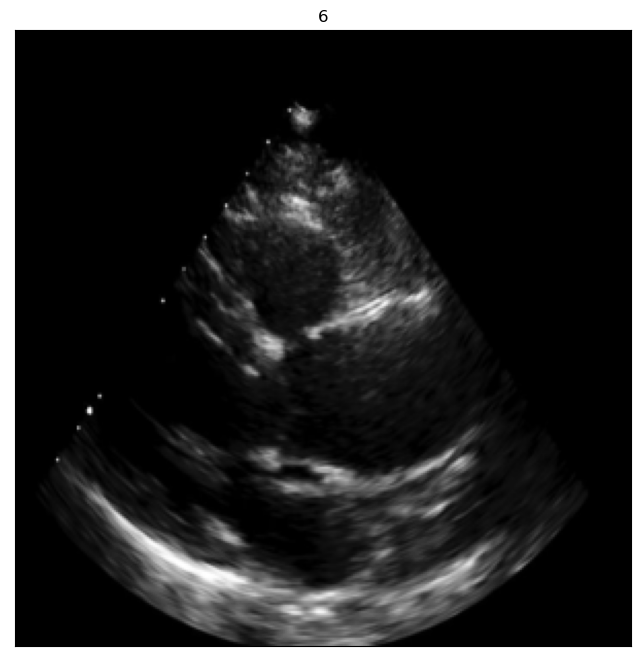

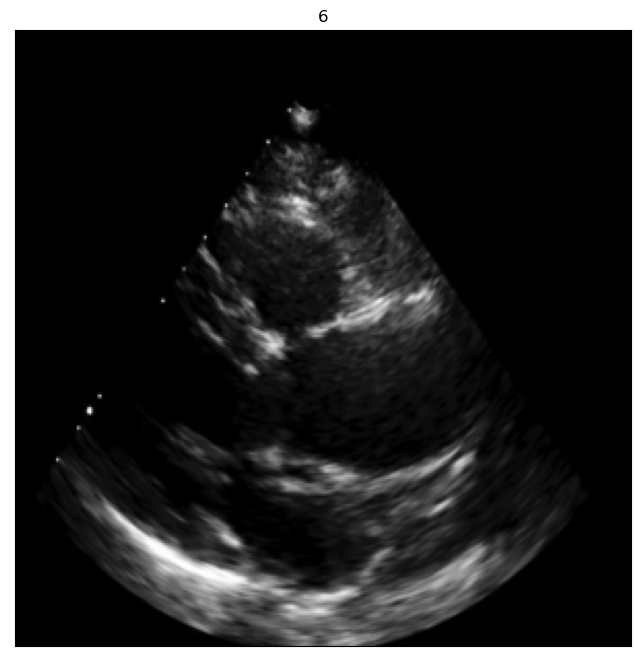

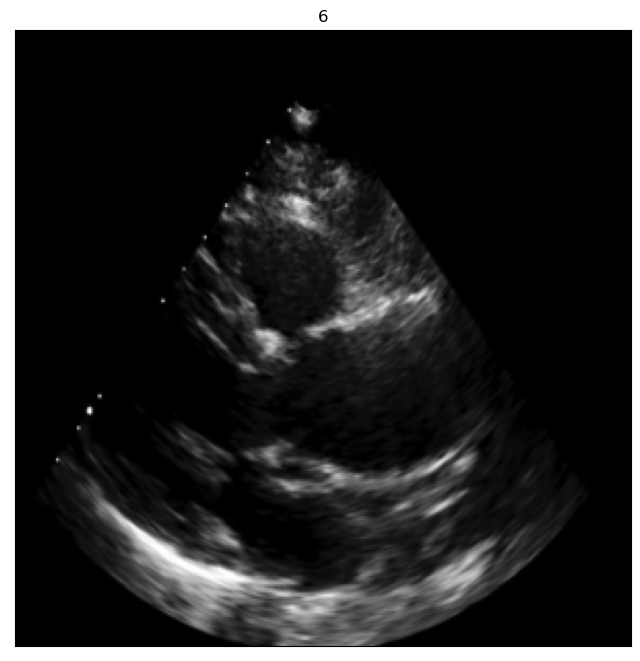

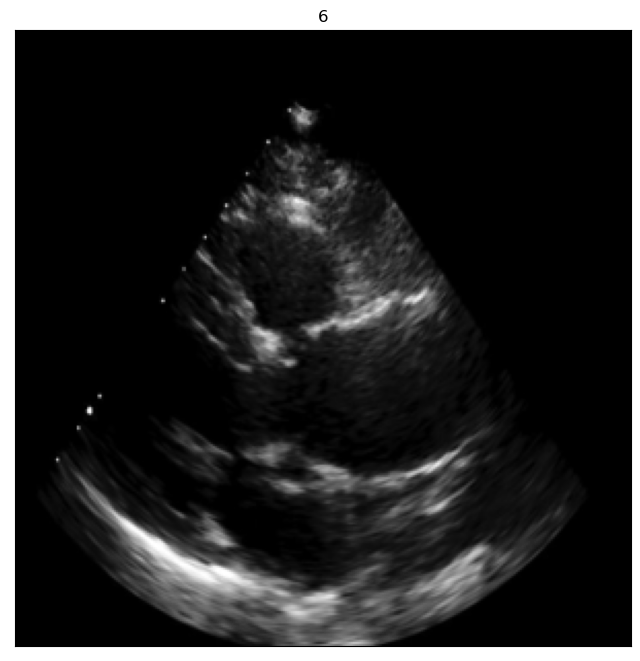

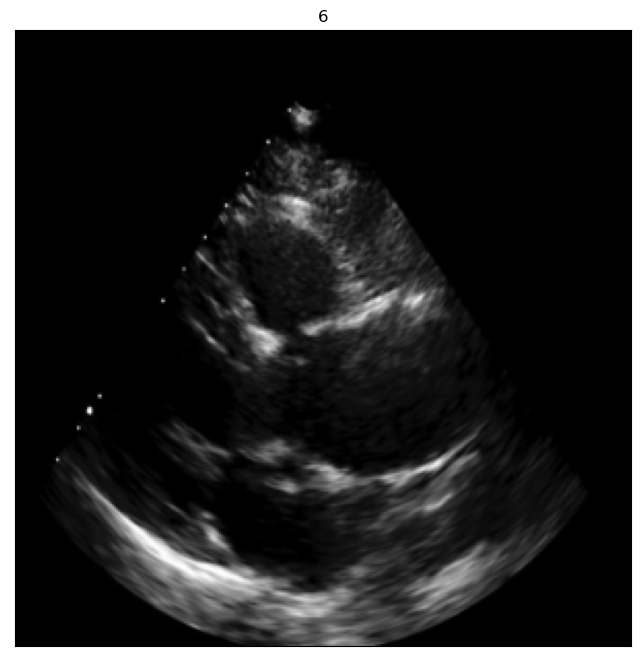

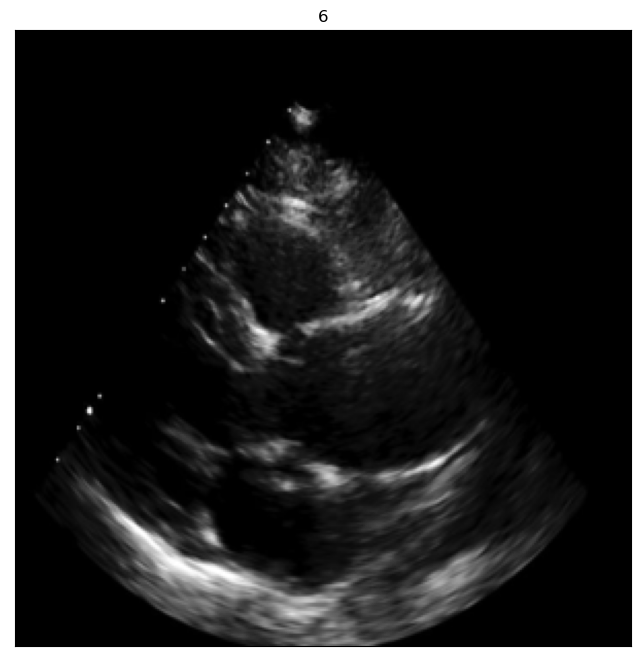

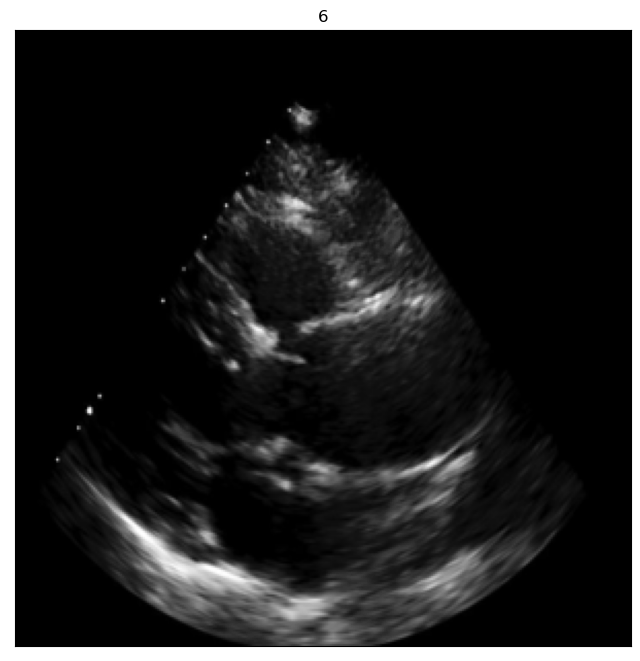

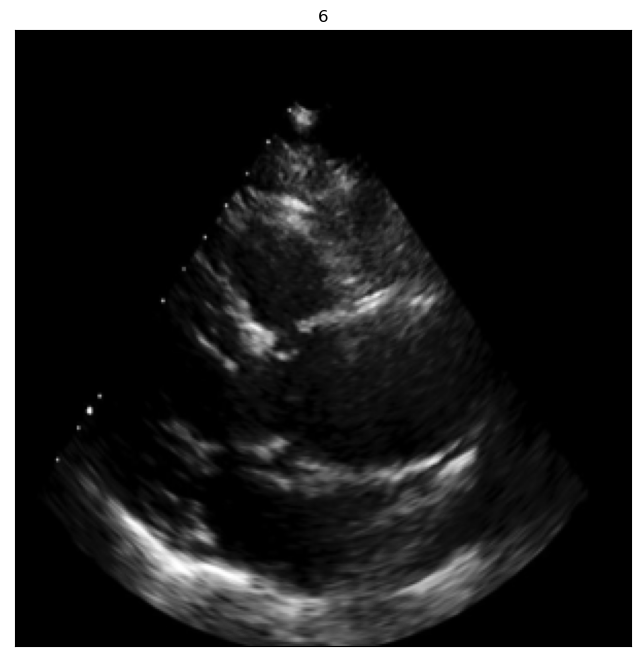

In [15]:
for image in total_data[900][0]:
    visualization(image[-1], total_data[100][1])


### Split the data into train, test and validation sets

In [16]:
total_len = len(total_data)
train_len = int(total_len * 0.8)
test_len = total_len - train_len

data, test_data = random_split(total_data, [train_len, test_len])

In [17]:
total_len = len(data)
train_len = int(total_len * 0.8)
val_data = total_len - train_len

train_data, val_data = random_split(data, [train_len, val_data])

### Create data loaders for the train and validation sets



In [18]:
train_loader = DataLoader(train_data, batch_size=32, drop_last=True, shuffle=True, pin_memory=True, num_workers= 8, persistent_workers=True)
#, pin_memory=True, num_workers= 8, persistent_workers=True)

val_loader = DataLoader(val_data, batch_size=32, drop_last=True, shuffle=False, pin_memory=True, num_workers= 8, persistent_workers=True)
#pin_memory=True, num_workers= 8, persistent_workers=True)

test_loader = DataLoader(test_data, batch_size=32, drop_last=True, shuffle=False, pin_memory=True, num_workers= 8, persistent_workers=True)
#pin_memory=True, num_workers= 8, persistent_workers=True)


### Define the neural network model architecture

In [20]:
class CNNLSTM(nn.Module):
    def __init__(self, in_channels, cnn_output_size, num_classes):
        super(CNNLSTM, self).__init__()

        self.hidden_size = 1000
        self.num_layers = 2
        self.num_classes = num_classes
        self.cnn_output_size = cnn_output_size

        # self.conv = torchvision.models.resnet18(pretrained = True)
        # self.conv = EfficientNet.from_pretrained('efficientnet-b0')
        self.conv = torchvision.models.inception_v3(weights='DEFAULT')
        # self.conv.trainable = False
        # for param in self.conv.parameters():
        #     param.requires_grad = False

        self.lstm = nn.LSTM(self.cnn_output_size, self.hidden_size, self.num_layers, batch_first=True)
        # self.classifier_layer = nn.Sequential( 
        #     nn.Linear(self.hidden_size, 256), 
        #     nn.ReLU(),
        #     nn.Dropout(0.2), 
        #     nn.Linear(256, num_classes))
        self.classifier_layer = nn.Sequential( nn.Linear(self.hidden_size, num_classes))

    def forward(self, x):
        batch_size , seq_len, C, H, W = x.size()
        c_in = x.view( batch_size * seq_len, C, H, W)
        # print(c_in.shape)
        c_out = self.conv(c_in)
        if self.training: #JUST FOR INCEPTION
            c_out = c_out[0]
        
        # c_out = F.adaptive_avg_pool2d(c_out, (1,1))
        
        # c_out = c_out.view(c_out.size(0), -1)
        # print(c_out)
        lstm_in = c_out.view(batch_size, seq_len, -1)
        # print(lstm_in.shape)
        lstm_out, _ = self.lstm(lstm_in)

        lstm_out = lstm_out[:, -1, :]

        output = self.classifier_layer(lstm_out)
        return output


cnn_output_size = 1000
model = CNNLSTM(3,cnn_output_size, 11)

In [21]:
# class CNN3D(nn.Module):
#     def __init__(self, cnn_output_size, num_classes):
#         super(CNN3D, self).__init__()

#         self.num_classes = num_classes
#         self.cnn_output_size = cnn_output_size

#         self.conv3 = torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50', pretrained=True)
#         self.classifier_layer = nn.Sequential( nn.Linear(self.cnn_output_size, num_classes))

#     def forward(self, x):
#         batch_size , seq_len, C, H, W = x.size()
#         c_in = x.view( batch_size, C, seq_len, H, W)
#         # print(c_in.shape)
#         c_out = self.conv3(c_in)
#         C_out = c_out.view(batch_size, -1)
#         output = self.classifier_layer(c_out)
#         return output


# cnn_output_size = 400
# model = CNN3D(cnn_output_size, 11)

In [22]:
# input1 = torch.rand(8, 10, 3, 299, 299)
# input2 = torch.rand(8, 10, 3, 299, 299)
# model.eval()
# print(model(input1))
# print(model(input2))

### Define loss and optimizer

In [24]:
torch.cuda.is_available()
# !export CUDA_VISIBLE_DEVICES=0

True

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda:0')
model.to(device)
model.lstm.flatten_parameters() 
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")

  model = nn.DataParallel(model)


# model.lstm.flatten_parameters() 
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1, momentum=0.9)

print(device)

Let's use 2 GPUs!
cuda


### Train the model

In [26]:
def evaluate(model, loader, device, criterion, mode='validation'):
  model.eval()
  total_correct = 0
  total_loss = 0
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0) #TODO: if number of sampels increase more than one it SHOULD increase as well
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()
      # print(predictions, labels, labels == predictions, total_correct, total, images.size(0))

  # print(total_correct, total, accuracy)
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} epoch {epoch}: Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  return accuracy, loss



In [27]:
# model = model.to(device)
epochs = 60
# BATCH_SIZE = 64
accs = []
losses = []
for epoch in range(epochs):
  model.train()
  total = 0
  running_loss = 0.
  running_corrects = 0
  val_loss = 0.0
  # epochs_no_improve = 0
  best_val_loss = float('inf')
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    # print(images)
    # print(outputs)
    labels = labels.squeeze(1)
    loss = criterion(outputs, labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    optimizer.step()

    total += images.size(0)
    _, predictions = outputs.max(1)
    # print(predictions, labels)
    running_loss += loss.item() * images.size(0)
    running_corrects += (predictions == labels).sum()
    # total_loss += loss.item() * images.size(0)
  #   if (i%10 == 0):
  #     print(total_loss/total)
  # accuracy = total_correct / total
    # break
  if (epoch%10 == 0):
    torch.save(model.state_dict(), (f'/scratch/student/shokoofa/model{epoch}.pth'))

  epoch_loss = running_loss / total
  epoch_acc = running_corrects / total
  accs.append(epoch_acc)
  losses.append(epoch_loss)
  # loss = total_loss / total
  print(f'Train epoch {epoch}: Loss({epoch_loss:6.4f}, Accuracy ({epoch_acc:6.5f}) )')
  val_acc, val_loss = evaluate(model, val_loader, device, criterion, mode='valid')
  accs.append(val_acc)
  losses.append(val_loss)

  print('---')

  if(val_loss < best_val_loss):
    best_val_loss = val_loss
    epochs_no_improve = 0
    torch.save(model.state_dict(), (f'/home/student/shokoofa/Downloads/res_model{epoch}.pth'))
  else:
    epochs_no_improve += 1

  if epochs_no_improve > 5:
    print('no further improvement')
    break


/home/student/shokoofa/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Train epoch 0: Loss(1.8625, Accuracy (0.36917) )
valid epoch 0: Loss(4.0949),  Accuracy (0.2121))
---
Train epoch 1: Loss(1.5872, Accuracy (0.45763) )
valid epoch 1: Loss(1.9941),  Accuracy (0.3728))
---
Train epoch 2: Loss(1.4849, Accuracy (0.48517) )
valid epoch 2: Loss(2.0776),  Accuracy (0.3460))
---
Train epoch 3: Loss(1.4021, Accuracy (0.50212) )
valid epoch 3: Loss(1.5115),  Accuracy (0.4107))
---
Train epoch 4: Loss(1.1948, Accuracy (0.57468) )
valid epoch 4: Loss(1.8899),  Accuracy (0.3996))
---
Train epoch 5: Loss(1.1293, Accuracy (0.58422) )
valid epoch 5: Loss(1.5678),  Accuracy (0.5089))
---
Train epoch 6: Loss(1.0590, Accuracy (0.62341) )
valid epoch 6: Loss(1.2298),  Accuracy (0.5871))
---
Train epoch 7: Loss(0.9692, Accuracy (0.64301) )
valid epoch 7: Loss(1.3558),  Accuracy (0.5156))
---
Train epoch 8: Loss(0.9302, Accuracy (0.65731) )
valid epoch 8: Loss(1.9577),  Accuracy (0.4732))
---
Train epoch 9: Loss(0.9352, Accuracy (0.65784) )
valid epoch 9: Loss(1.5926),  Acc

KeyboardInterrupt: 

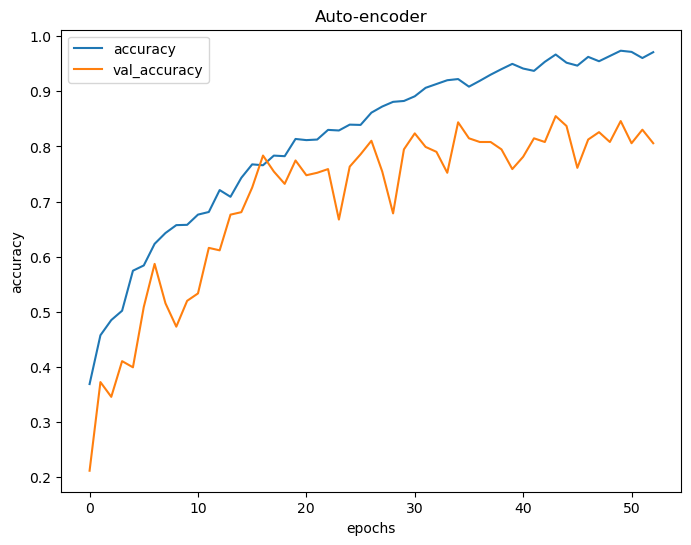

In [28]:
from numpy.core.multiarray import zeros
import matplotlib.pyplot as plt
import numpy as np


# Generate sample data
x = [i for i in range(0,len(accs)//2)]
y = [accs[i].cpu() for i in range(0,len(accs),2)]
z = [accs[i].cpu() for i in range(1,len(accs),2)]


# Create a new figure and set the size
fig = plt.figure(figsize=(8, 6))

# Add a new subplot to the figure
ax = fig.add_subplot(1, 1, 1)

# Plot the line graph
ax.plot(x, y, label='accuracy')
ax.plot(x, z, label='val_accuracy')
ax.legend()
# Set the title and axis labels
ax.set_title('Auto-encoder')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')

# Display the plot
plt.show()


In [ ]:
# predictions == labels

In [ ]:
# model.load_state_dict(torch.load('/home/student/shokoofa/Downloads/model0.pth'))
# model.eval()

In [ ]:
# print(model(test_data[183][0].unsqueeze(0).to(device)))
# # test_data[0][0].unsqueeze(0).shape
# # images.size()

# test_data[183][1]

In [ ]:
# class CNN(nn.Module):
#     def __init__(self, in_channels):
#         super(CNN, self).__init__()

#         self.conv = EfficientNet.from_pretrained('efficientnet-b0')
#         self.conv.trainable = False
#         for param in self.conv.parameters():
#             param.requires_grad = False

#     def forward(self, x):
#         seq_len, C, H, W = x.size()
#         c_in = x.view( seq_len, C, H, W)
#         c_out = self.conv.extract_features(c_in)
#         pooled = F.adaptive_avg_pool2d(c_out, (1,1))
#         pooled = pooled.view(seq_len, -1)
#         return pooled


# # x = torch.rand((1, 20, 1, 32, 32))
# xx = [torch.rand( i, 3, 224, 224) for i in range(25,30)]
# net_cnn = CNN(1)
# for x in xx:
#     features = net_cnn(x)
#     print(features.shape)

In [ ]:
# class VGG(nn.Module):
#   def __init__(self, num_classes=100):
#     super().__init__()
#     self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#     )

#     self.adaptive_avg_pool2d = nn.AdaptiveAvgPool2d((6, 6))
#     self.flatten = nn.Flatten(start_dim=1)
#     self.classifier = nn.Sequential(
#             nn.Linear(256*256*512, num_classes),
#             nn.ReLU(inplace=True),
#             # nn.Linear(1000, 100),
#             # nn.ReLU(inplace=True),
#             # nn.Linear(1000, num_classes),
#             # nn.ReLU(inplace=True),
#         )

#   def forward(self, x):
#     x = self.features(x)
#     # x = self.adaptive_avg_pool2d(x)
#     x = self.flatten(x)
#     x = self.classifier(x)
#     return x

In [ ]:
  # for i, (images, labels) in enumerate(train_loader):
  #   print(images.shape)
  #   break

In [ ]:
  # for i, (images, labels) in enumerate(train_loader):
  #   print(images.shape)
  #   break



In [ ]:
# torch.save(model.state_dict(), 'model.pt')
